# English-to-French translation by Transformer

In this notebook, I used the [transformer network](https://arxiv.org/abs/1706.03762) to translate the English sentences into French.


---
**The original paper**

A. Vaswani et al. (2017) **Attention Is All You Need**: https://arxiv.org/abs/1706.03762

---
**References**

This notebook is guided by following the Transformer tutorial notebook:

https://www.tensorflow.org/tutorials/text/transformer


---
**The dataset**

This notebook uses the dataset provided by [Udacity's NLP Nanodegree Course](https://www.udacity.com/course/natural-language-processing-nanodegree--nd892). The dataset is a subset extracted from the [WMT](http://www.statmt.org/) dataset. It contains 137,861 English sentences and their translations in French.

To run this notebook, simply upload the training data onto the Google Colab workspace (assuming that you have those files). If you don't have the files I used, you can upload your own dataset (even in different languages), and rewrite your data preprocessing codes.

---
**Computing resource**

This notebook was run on Google Colab

# Import libraries

In [1]:
%matplotlib inline

import os

import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, LSTM, GRU, Input, Dense, TimeDistributed, Activation
from tensorflow.keras.layers import RepeatVector, Bidirectional, Attention, Concatenate, Dot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy

import matplotlib.pyplot as plt


"""
The code below is used to confirm that we're using GPU
"""

print(tf.__version__)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

print("\n")

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

2.3.0
Found GPU at: /device:GPU:0


Sun Oct  4 21:32:04 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    39W / 300W |    433MiB / 16130MiB |      7%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                    

# Load the dataset

Load the dataset (it could be your own dataset) from the working directory

In [2]:
## Load English sentences
with open('small_vocab_en', 'r') as f:
    eng_raw_data = f.read()
          
english_sentences = eng_raw_data.split('\n')

## Load French sentences
with open('small_vocab_fr', 'r') as f:
    fr_raw_data = f.read()
          
french_sentences = fr_raw_data.split('\n')

In [3]:
## Display some info

print("sentences in the English corpus: {}".format(len(english_sentences)))
print("sentences in the French corpus: {}".format(len(french_sentences)))

print("\n")

print("first 3 English/French sentences:\n")

for i in range(3):
    print(english_sentences[i])
    print(french_sentences[i])
    print("\n")

sentences in the English corpus: 137861
sentences in the French corpus: 137861


first 3 English/French sentences:

new jersey is sometimes quiet during autumn , and it is snowy in april .
new jersey est parfois calme pendant l' automne , et il est neigeux en avril .


the united states is usually chilly during july , and it is usually freezing in november .
les états-unis est généralement froid en juillet , et il gèle habituellement en novembre .


california is usually quiet during march , and it is usually hot in june .
california est généralement calme en mars , et il est généralement chaud en juin .




We use `collections.Counter` to count the distinct words in both languages, and use the `most_common()` method to see the most frequently used words

In [4]:
from collections import Counter

## Size of the English vocabulary
english_corpus = [w for sentence in english_sentences for w in sentence.split()]
english_vocab_counter = Counter(english_corpus)
english_vocab_size = len(english_vocab_counter)

print("Size of the English corpus: {}".format(len(english_corpus)))
print("Vocab size of English: {}".format(english_vocab_size))
print("10 most frequent English vocab: {}".format([x[0] for x in english_vocab_counter.most_common(10)]))
print("longest length of sentence: {}".format(max(len(sentence.split()) for sentence in english_sentences)))
print("\n")

## Size of the French vocabulary
french_corpus = [w for sentence in french_sentences for w in sentence.split()]
french_vocab_counter = Counter(french_corpus)
french_vocab_size = len(french_vocab_counter)

print("Size of the French corpus: {}".format(len(french_corpus)))
print("Vocab size of French: {}".format(french_vocab_size))
print("10 most frequent French vocab: {}".format([x[0] for x in french_vocab_counter.most_common(10)]))
print("longest length of sentence: {}".format(max(len(sentence.split()) for sentence in french_sentences)))

Size of the English corpus: 1823250
Vocab size of English: 227
10 most frequent English vocab: ['is', ',', '.', 'in', 'it', 'during', 'the', 'but', 'and', 'sometimes']
longest length of sentence: 17


Size of the French corpus: 1961295
Vocab size of French: 355
10 most frequent French vocab: ['est', '.', ',', 'en', 'il', 'les', 'mais', 'et', 'la', 'parfois']
longest length of sentence: 23


We see that the longest length of English sentences is 17, and the longest length of French sentences is 23

# Create training, validation, and test datasets

We use `sklearn.model_selection.train_test_split` split the dataset (137,861 sentences) into:

- training dataset of 120,000 sentences,

- validation dataset of 7,861 sentences, and

- test dataset of 10,000 sentences

In [5]:
## Split into 120000 training, 7861 validation, and 10000 test data

from sklearn.model_selection import train_test_split

# separate test data
X_train_valid, X_test, Y_train_valid, Y_test = train_test_split(english_sentences, french_sentences, test_size = 10000, random_state = 1)

# separate train and validation data
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train_valid, Y_train_valid, test_size = 7861, random_state = 1)

# check sizes
print("number of training data: {} / {}".format(len(X_train), len(Y_train)))
print("number of valid data: {} / {}".format(len(X_valid), len(Y_valid)))
print("number of test data: {} / {}".format(len(X_test), len(Y_test)))


number of training data: 120000 / 120000
number of valid data: 7861 / 7861
number of test data: 10000 / 10000


# Build TensorFlow input pipelines

Use `tf.data.Dataset.from_tensor_slices` to convert the data into tensorflow dataset

In [180]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))

next(iter(train_dataset))

(<tf.Tensor: shape=(), dtype=string, numpy=b'california is usually hot during july , and it is never wet in april .'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'californie est g\xc3\xa9n\xc3\xa9ralement chaud en juillet , et il est jamais humide en avril .'>)

# Tokenize the words

We use the method `build_from_corpus` of `tfds.features.text.SubwordTextEncoder` to tokenize the English and French sentences

The [SubwordTextEncoder](https://www.tensorflow.org/datasets/api_docs/python/tfds/features/text/SubwordTextEncoder) can encode a word by its subwords if that word was not seen in its dictionaty.

We specified the `vocab_size` so that the tokens wll give integers from [1, vocab_size)


In [181]:
## Subword Tokenizer

english_tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus((eng.numpy() for eng, fr in train_dataset), target_vocab_size = 2**13)
french_tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus((fr.numpy() for eng, fr in train_dataset), target_vocab_size = 2**13)

The test below will tokenize an English sentence into tokens by the `encode` method of the tokenizer. The token will then be decoded back by using the `decode` method. After decoding we should get the original sentence

In [182]:
## Test the tokenization

sample_sentence = X_valid[100]

encoded_sample_sentence = english_tokenizer.encode(sample_sentence)

print("input sentence: {}".format(sample_sentence))
print("tokens: {}".format(encoded_sample_sentence))
print("tokenized sentence: {}".format(english_tokenizer.decode(encoded_sample_sentence)))
print("\n")

print("detail of tokenizing:")
for k in encoded_sample_sentence:
    print("{} ---> {}".format(k, english_tokenizer.decode([k])))

print("\n")
## More sanity check on the first 5 sentences in the training dataset
for i in range(5):
    print(X_train[i] == english_tokenizer.decode(english_tokenizer.encode(X_train[i])))

input sentence: the pear is your most loved fruit , but the grapefruit is her most loved .
tokens: [7, 107, 1, 31, 15, 27, 16, 2, 8, 7, 92, 1, 34, 15, 89, 3]
tokenized sentence: the pear is your most loved fruit , but the grapefruit is her most loved .


detail of tokenizing:
7 ---> the 
107 ---> pear 
1 ---> is 
31 ---> your 
15 ---> most 
27 ---> loved 
16 ---> fruit
2 --->  , 
8 ---> but 
7 ---> the 
92 ---> grapefruit 
1 ---> is 
34 ---> her 
15 ---> most 
89 ---> loved
3 --->  .


True
True
True
True
True


# The tokenize+pad function

The tokenize function takes a list of sentences and its language tokenizer as inputs. It tokenizes the sentences, and add a **start token** and an **end token** in each sentence

There are in total N tokens in the tokenizer, with labels from 1 to N-1.

We use **N as the start token**, and **N+1 as the end token**.

To get N, we use the `vocab_size` attribute of the tokenizer

In [183]:
def tokenize(eng_sentence, fr_sentence):

    eng_sentence = [english_tokenizer.vocab_size] + english_tokenizer.encode(eng_sentence.numpy()) + [english_tokenizer.vocab_size+1]
    fr_sentence =  [french_tokenizer.vocab_size] + french_tokenizer.encode(fr_sentence.numpy()) + [french_tokenizer.vocab_size+1]

    return eng_sentence, fr_sentence


def tf_tokenize(eng_sentence, fr_sentence):

    res_eng, res_fr = tf.py_function(tokenize, [eng_sentence, fr_sentence], [tf.int64, tf.int64])

    res_eng.set_shape([None])
    res_fr.set_shape([None])

    return res_eng, res_fr


def filter_max_length(x, y, max_length = MAX_LENGTH):

  return tf.logical_and(tf.size(x) <= max_length, tf.size(y) <= max_length)

In [186]:
MAX_LENGTH = 25             # maximum length of the input sentence
BUFFER_SIZE = 20000         # the size of the shuffle buffer
BATCH_SIZE = 64             # the batch size

# Propress the training data

The code below tokenizes, add SOS & EOS, filter out sentences that are too long

In [187]:
# tokenize the training dataset
train_dataset = train_dataset.map(tf_tokenize)
# remove sentences that are too long
train_dataset = train_dataset.filter(filter_max_length)
# cache the data to memory
train_dataset = train_dataset.cache()
# shuffle
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
# prefetching
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [188]:
# see a batch
eng_batch, fr_batch = next(iter(train_dataset))
eng_batch, fr_batch

(<tf.Tensor: shape=(64, 19), dtype=int64, numpy=
 array([[528,  93,  87, ...,   0,   0,   0],
        [528,  28,  72, ...,   0,   0,   0],
        [528,  24,   1, ..., 529,   0,   0],
        ...,
        [528,  33,  15, ...,   0,   0,   0],
        [528,  21,   1, ...,   0,   0,   0],
        [528,   7, 115, ...,   3, 529,   0]])>,
 <tf.Tensor: shape=(64, 23), dtype=int64, numpy=
 array([[717, 141, 571, ...,   0,   0,   0],
        [717,  30,  29, ...,   0,   0,   0],
        [717,   9,  35, ...,   0,   0,   0],
        ...,
        [717, 190, 162, ...,   0,   0,   0],
        [717, 569,  10, ...,   0,   0,   0],
        [717, 569, 500, ...,   0,   0,   0]])>)

# Preprocess the validation data

We put all the validation data into a single tensor. We evaluate the model on validation data after a complete episode

In [ ]:
## validation data preprocessing


# Hyperparameters

In [256]:
num_layers = 6       # number of layers (original paper used 6)
d_model = 512        # dimension of embedding (original paper used 512)
ff_units = 512       # number of units used in the position-wise feed-forward networks (original paper used 2048)
num_heads = 8        # number of heads in the multi-head attention  (original paper used 8)

dropout_rate = 0.1   # the rate of dropout (original paper used 0.1)

input_vocab_size = english_tokenizer.vocab_size + 2
output_vocab_size = french_tokenizer.vocab_size + 2

# Positional Encoding

Positional encoding enables the input word to carry information about it's spatial location in the input sentence.

Positional encoding is performed after the input sentence was passed through the embedding layer, with the shape (batch_size, d_model)


In [12]:
def get_PE_angle(pos, i, d_model):
    """
    Calculate the angle used in the positional encoding. The equations:

    PE_angle(pos, 2k) = pos/10000**(2k/d_model)     if i is even, i = 2*k ; if i is odd, i = 2*k + 1

    inputs:
            pos: the position
            i: the dimension
            d_model: embedding dimension
    
    output:
            PE_angle: the PE angle 
    """

    k = i // 2
    denominator = np.power(10000, 2*k/np.float32(d_model))
    PE_angle = pos / denominator

    return PE_angle


def Positional_Encoding(num_positions, d_model):
    """
    Calculate the positional encoding vector

    PE(pos, 2k) = sin(pos/10000**(2k/d_model))     if i is even, i = 2*k
    PE(pos, 2k+1) = cos(pos/10000**(2k/d_model))   if i is odd,  i = 2*k + 1

    inputs:
            num_positions: number of positions
            d_model: embedding dimension
    """

    PE_angles = get_PE_angle(pos = np.arange(num_positions)[:, np.newaxis], # shape (num_positions, 1)
                             i = np.arange(d_model)[np.newaxis, :],         # shape (1, d_model)
                             d_model = d_model)
    
    ## after broadcasting, PE_angles has the shape (num_positions, d_model)
    assert PE_angles.shape == (num_positions, d_model)

    # odd indeces
    PE_angles[:, 1::2] = np.cos(PE_angles[:, 1::2])

    # even indeces
    PE_angles[:, 0::2] = np.sin(PE_angles[:, 0::2])

    # append a new dimention
    res = PE_angles[np.newaxis, ...] # shape (1, num_positions, d_model)

    return tf.cast(res, dtype = tf.float32)

#Padding Mask

Masking will be performed on padded zeros

In [134]:
## Masking on padded zeros

def create_padding_mask(x):
    """
    Create a tensor of booleans, the value is 1 if there's a padded zero. The value is 0 is it is not zero.

    input
            x: the input vector
    
    output
            padding_mask (dtype = tf.float32)
    """

    padding_boolean = tf.cast(tf.math.equal(x, 0), tf.float32)

    padding_mask = padding_boolean[:, tf.newaxis, tf.newaxis, :] # (batch_size, 1, 1, sentence_length)

    return padding_mask

# Look-ahead mask

This mask masks the future tokens

The code uses `tf.linalg.band_part` to set values outside the band to be 0

In [136]:
def create_lookahead_mask(size):

    lookahead_mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)

    return lookahead_mask

# Scaled Dot-Product Attention

In [138]:
def SDP_Attention(Q, K, V, mask):
    """
    Calculate the weights of the scaled dot product attention
    Equation: SDP_Attention(Q, K, V, mask) = softmax_k(Q transpose(K) / sqrt(d_k)) <matmul>  V

    inputs:
            Q - query
            K - key
            V - value
            mask - mask

    outputs:
            SDP_attention - softmax_k(Q transpose(K) / sqrt(d_k)) <matmul>  V
            weights       - softmax_k(Q transpose(K) / sqrt(d_k))
    """

    QK = tf.matmul(Q, K, transpose_b = True)

    # calculate d_k
    d_k = tf.cast(tf.shape(K)[-1], tf.float32)

    # logits
    logits = QK / tf.math.sqrt(d_k)

    # mask
    if mask is not None:
        logits += (mask * -1e9)

    # calculate weights
    W = tf.nn.softmax(logits, axis = -1)

    return tf.matmul(W, V), W


# Multi-Head Attention

In [152]:
class MHA(tf.keras.layers.Layer):
    
    def __init__(self, d_model, num_heads):

        super(MHA, self).__init__()

        assert d_model % num_heads == 0

        self.num_heads = num_heads
        self.d_model = d_model

        self.depth = d_model // self.num_heads

        self.dense_Q = tf.keras.layers.Dense(d_model)
        self.dense_K = tf.keras.layers.Dense(d_model)
        self.dense_V = tf.keras.layers.Dense(d_model)

        self.dense_out = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """
        split the last dimension into (self.num_heads, self.depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))

        return tf.transpose(x, perm = [0, 2, 1, 3])


    def call(self, V, K, Q, mask):
        
        batch_size = tf.shape(Q)[0]

        V = self.dense_V(V)
        K = self.dense_K(K)
        Q = self.dense_Q(Q)

        V = self.split_heads(V, batch_size)
        K = self.split_heads(K, batch_size)
        Q = self.split_heads(Q, batch_size)
        
        scaled_attention, attention_weights = SDP_Attention(Q, K, V, mask) # args: Q, K, V, mask

        scaled_attention = tf.transpose(scaled_attention, perm = [0, 2, 1, 3])

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

        output = self.dense_out(concat_attention)

        return output, attention_weights

# Point wise feed forward network

In [191]:
def Point_Wise_Feed_Forward(d_model, ff_units):

    model = tf.keras.Sequential([tf.keras.layers.Dense(ff_units, activation = 'relu'),
                                 tf.keras.layers.Dense(d_model)])

    return model

# Encoder Layer

The encoder block contains:

1. Multi-Head Attention
2. Add residual and normalize
3. Point-wise feed forward
4. Add residual and normalize

In [197]:
class EncoderLayer(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, ff_units, dropout_rate = 0.1):

        super(EncoderLayer, self).__init__()

        self.MHA = MHA(d_model, num_heads)
        self.FF = Point_Wise_Feed_Forward(d_model, ff_units)

        self.Norm1 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)
        self.Norm2 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)

        self.Dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.Dropout2 = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, training_bool, mask):

        attention, _ = self.MHA(x, x, x, mask)
        attention = self.Dropout1(attention, training = training_bool)
        
        y = self.Norm1(x + attention)

        ff = self.FF(y)
        ff = self.Dropout2(ff, training = training_bool)

        output = self.Norm2(y + ff)

        return output

# Encoder

In [201]:
class Encoder(tf.keras.layers.Layer):

    def __init__(self, num_layers, d_model, num_heads, ff_units, input_vocab_size, max_position_encoding, dropout_rate = 0.1):

        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.Embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.PositionalEncoding = Positional_Encoding(max_position_encoding, d_model)

        self.EncoderLayers = [EncoderLayer(d_model, num_heads, ff_units, dropout_rate) for _ in range(num_layers)]

        self.Dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, training, mask):

        seq_len = tf.shape(x)[1]

        x = self.Embedding(x)

        x *= tf.math.sqrt(tf.cast(self.d_model, dtype = tf.float32))

        x += self.PositionalEncoding[:, :seq_len, :]

        x = self.Dropout(x, training = training)

        for i in range(self.num_layers):
            x = self.EncoderLayers[i](x, training, mask)

        return x

# Decoder Layer

1. MHA
2. Add residual and norm
3. MHA (V = K = output_from_encoder_block, Q = output_from_2)
4. add residual (output_from_2) and norm
5. feed forward
6. add residual and norm

In [193]:
class DecoderLayer(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, ff_units, dropout_rate = 0.1):

        super(DecoderLayer, self).__init__()

        self.MHA1 = MHA(d_model, num_heads)
        self.MHA2 = MHA(d_model, num_heads)

        self.FF = Point_Wise_Feed_Forward(d_model, ff_units)

        self.Dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.Dropout2 = tf.keras.layers.Dropout(dropout_rate)
        self.Dropout3 = tf.keras.layers.Dropout(dropout_rate)

        self.Norm1 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)
        self.Norm2 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)
        self.Norm3 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)
        

    def call(self, x, encoder_output, training_bool, look_ahead_mask, padding_mask):

        attention_1, attention_weights_1 = self.MHA1(x, x, x, look_ahead_mask)
        attention_1 = self.Dropout1(attention_1, training = training_bool)
        y1 = self.Norm1(attention_1 + x)

        attention_2, attention_weights_2 = self.MHA2(encoder_output, encoder_output, y1, padding_mask)
        attention_2 = self.Dropout2(attention_2, training = training_bool)
        y2 = self.Norm2(attention_2 + y1)
        
        ff = self.FF(y2)
        ff = self.Dropout3(ff, training = training_bool)
        y3 = self.Norm3(ff + y2)
        
        return y3, attention_weights_1, attention_weights_2

# Decoder

In [204]:
class Decoder(tf.keras.layers.Layer):

    def __init__(self, num_layers, d_model, num_heads, ff_units, output_vocab_size, max_position_encoding, dropout_rate = 0.1):

        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        # embedding layer
        self.Embedding = tf.keras.layers.Embedding(output_vocab_size, d_model)
        # positional encoding
        self.PositionalEncoding = Positional_Encoding(max_position_encoding, d_model)
        # dropout
        self.Dropout = tf.keras.layers.Dropout(dropout_rate)
        # decode layers
        self.DecodeLayers = [DecoderLayer(d_model, num_heads, ff_units, dropout_rate) for _ in range(num_layers)]


    def call(self, x, encoder_output, training, look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]

        attention_weights = {}

        # embedding
        x = self.Embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        # positional encoding
        x += self.PositionalEncoding[:, :seq_len, :]
        # dropout
        x = self.Dropout(x, training = training)

        for i in range(self.num_layers):

            x, aw1, aw2 = self.DecodeLayers[i](x, encoder_output, training, look_ahead_mask, padding_mask)

            attention_weights["AW1_{}".format(i+1)] = aw1
            attention_weights["AW2_{}".format(i+1)] = aw2
        
        return x, attention_weights

# Build Transformer

In [206]:
class Transformer(tf.keras.Model):

    def __init__(self, num_layers, d_model, num_heads, ff_units, input_vocab_size, output_vocab_size, pe_input, pe_target, dropout_rate = 0.1):

        super(Transformer, self).__init__()

        self.Encoder = Encoder(num_layers, d_model, num_heads, ff_units, input_vocab_size, pe_input, dropout_rate)
        self.Decoder = Decoder(num_layers, d_model, num_heads, ff_units, output_vocab_size, pe_target, dropout_rate)
        self.Dense = tf.keras.layers.Dense(output_vocab_size)

    def call(self, x, y, training, encoder_padding_mask, look_ahead_mask, decoder_padding_mask):

        encoder_output = self.Encoder(x, training, encoder_padding_mask)

        decoder_output, attention_weights = self.Decoder(y, encoder_output, training, look_ahead_mask, decoder_padding_mask)

        final_output = self.Dense(decoder_output)

        return final_output, attention_weights

# Optimizer with scheduled learning rate

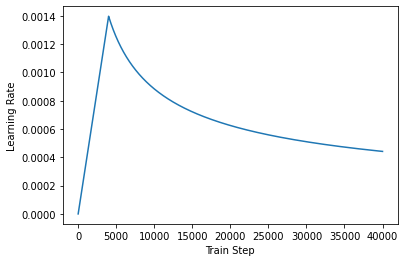

In [253]:
class Scheduled_LR(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps = 4000):

        super(Scheduled_LR, self).__init__()


        # cast the parameters to tf.float32 in order to use tf.math.rsqrt() function later
        self.d_model = tf.cast(d_model, dtype = tf.float32)
        self.warmup_steps = tf.cast(warmup_steps, dtype = tf.float32)

    def __call__(self, step_num):
        """
        Determine the learning rate at step = t

        lrate = rsqrt(d_model)*min(rsqrt(step_num), step_num*rsqrt(warmup_steps**3))
        """

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(tf.math.rsqrt(step_num), step_num*tf.math.rsqrt(self.warmup_steps**3))


# Plot the learning rate
temp_learning_rate_schedule = Scheduled_LR(d_model = 128)

lr = temp_learning_rate_schedule(tf.range(40000, dtype = tf.float32))

plt.plot(lr)
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")


## Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate = Scheduled_LR(d_model), beta_1 = 0.9, beta_2 = 0.98, epsilon = 1e-9)

# Loss and metrics

In [167]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = 'none')

def loss_function(real, prediction):

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_  = loss_object(real, prediction)

    mask = tf.cast(mask, dtype = loss_.dtype)
    loss_  *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


train_loss = tf.keras.metrics.Mean(name = 'train_loss')
train_acc = tf.keras.metrics.SparseCategoricalAccuracy(name = 'train_acc')

# Helper function to create masks

In [209]:
def create_masks(input, target):

    # padding masks
    encoder_padding_mask = create_padding_mask(input)
    decoder_padding_mask = create_padding_mask(input)

    # lookahead mask
    lookahead_mask = create_lookahead_mask(tf.shape(target)[1])
    decoder_target_padding_mask = create_padding_mask(target)
    combined_mask = tf.maximum(lookahead_mask, decoder_target_padding_mask)

    return encoder_padding_mask, combined_mask, decoder_padding_mask

# Training

In [255]:
train_step_signature = [tf.TensorSpec(shape=(None, None), dtype = tf.int64), tf.TensorSpec(shape=(None, None), dtype = tf.int64)]

@tf.function(input_signature = train_step_signature)
def train_step(input, target):
    target_input = target[:, :-1]
    target_real = target[:, 1:]

    encoder_padding_mask, combined_mask, decoder_padding_mask = create_masks(input, target_input)

    with tf.GradientTape() as tape:

        # arguments of transformer: x, y, training_bool, encoder_padding_mask, look_ahead_mask, decoder_padding_mask
        predictions, _ = transformer(x = input,
                                    y = target_input,
                                    training = True,
                                    encoder_padding_mask = encoder_padding_mask,
                                    look_ahead_mask = combined_mask,
                                    decoder_padding_mask = decoder_padding_mask)

        loss = loss_function(target_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_acc(target_real, predictions)


In [257]:
import time

EPOCHS = 20


## create the transformer
transformer = Transformer(num_layers, d_model, num_heads, ff_units, input_vocab_size, output_vocab_size, input_vocab_size, output_vocab_size, dropout_rate = 0.1)

for epoch in range(EPOCHS+1):

    start = time.time()

    train_loss.reset_states()
    train_acc.reset_states()

    for (batch, (input, target)) in enumerate(train_dataset):

        train_step(input, target)
        
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f} Acc {:.4f}'.format(epoch, batch, train_loss.result(), train_acc.result()))
    

    print('Epoch {} Loss {:.4f} Acc {:.4f}'.format(epoch, train_loss.result(), train_acc.result()))

    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 0 Batch 0 Loss 6.9463 Acc 0.0028
Epoch 0 Batch 100 Loss 5.4884 Acc 0.0506
Epoch 0 Batch 200 Loss 4.6264 Acc 0.1108
Epoch 0 Batch 300 Loss 3.7902 Acc 0.2070
Epoch 0 Batch 400 Loss 3.1575 Acc 0.2822
Epoch 0 Batch 500 Loss 2.7018 Acc 0.3373
Epoch 0 Batch 600 Loss 2.3610 Acc 0.3795
Epoch 0 Batch 700 Loss 2.1002 Acc 0.4120
Epoch 0 Batch 800 Loss 1.8950 Acc 0.4384
Epoch 0 Batch 900 Loss 1.7282 Acc 0.4606
Epoch 0 Batch 1000 Loss 1.5902 Acc 0.4795
Epoch 0 Batch 1100 Loss 1.4735 Acc 0.4958
Epoch 0 Batch 1200 Loss 1.3746 Acc 0.5097
Epoch 0 Batch 1300 Loss 1.2896 Acc 0.5220
Epoch 0 Batch 1400 Loss 1.2155 Acc 0.5322
Epoch 0 Batch 1500 Loss 1.1501 Acc 0.5416
Epoch 0 Batch 1600 Loss 1.0925 Acc 0.5501
Epoch 0 Batch 1700 Loss 1.0414 Acc 0.5572
Epoch 0 Batch 1800 Loss 0.9954 Acc 0.5638
Epoch 0 Loss 0.9639 Acc 0.5684
Time taken for 1 epoch: 160.63922953605652 secs

Epoch 1 Batch 0 Loss 0.1839 Acc 0.7031
Epoch 1 Batch 100 Loss 0.1948 Acc 0.6869
Epoch 1 Batch 200 Loss 0.1959 Acc 0.6828
Epoch 1 Batch

# Model Evaluation

In [258]:
def evaluate(eng_sentence):

    # tokenize and add SOS & EOS
    input = [english_tokenizer.vocab_size] + english_tokenizer.encode(eng_sentence) + [english_tokenizer.vocab_size+1]
    input = np.asarray(input)
    input = input[np.newaxis, :]

    # target French sentence
    target_input = [french_tokenizer.vocab_size] # SOS of French
    target_input = np.asarray(target_input)
    target_input = target_input[np.newaxis, :]

    for i in range(MAX_LENGTH):
        encoder_padding_mask, combined_mask, decoder_padding_mask = create_masks(input, target_input)

        prediction, _ = transformer(x = input,
                                    y = target_input,
                                    training = True,
                                    encoder_padding_mask = encoder_padding_mask,
                                    look_ahead_mask = combined_mask,
                                    decoder_padding_mask = decoder_padding_mask)

        prediction = prediction[:, -1:, :]

        prediction_index = tf.cast(tf.argmax(prediction, axis = -1), tf.int32)

        # stop if EOS is predicted
        if prediction_index == french_tokenizer.vocab_size + 1:
            return tf.squeeze(target_input, axis = 0)

        target_input = tf.concat([target_input, prediction_index], axis = -1)

    return tf.squeeze(target_input, axis = 0)


def translate(eng_sentence, fr_sentence):

    translation = french_tokenizer.decode([w for w in evaluate(eng_sentence) if w < french_tokenizer.vocab_size])

    print("[eng]\n{}".format(eng_sentence))
    
    print("[fr]\n{}".format(translation))

    if fr_sentence:
        print("[ans]\n{}".format(fr_sentence))

# Translation by Transformer

In [259]:
idx = np.random.randint(low = 0, high = len(X_test))

translate(X_test[idx], Y_test[idx])

[eng]
new jersey is sometimes wet during october , and it is usually rainy in spring .
[fr]
new jersey est parfois humide en octobre , et il est généralement pluvieux au printemps .
[ans]
new jersey est parfois humide en octobre , et il est généralement pluvieux au printemps .
